In [1]:
%load_ext autoreload
%autoreload 2

import dask
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize
import pymc as pm
import arviz as az
import corner
import pickle
import cloudpickle

from normalization_utils import fit_combo_scaler, inverse_combo_scaler

np.random.seed(42)

### Select dataset to work with here

Uncomment one of these lines only to define the dataset we're working with.

Key to BedMachine Masks:

0. Ocean
1. Ice-free land
2. Grounded
3. Floating

In [2]:
dataset_name, ice_sheet, bm_mask_whitelist, input_data_path = (
    "cresis_gis_grounded", "greenland", [2], 
    "../data_preprocessing/snr_data_cresis_gis_with_inputs.nc"
)

In [3]:
# Remove any missing values and subset to variables of interest
input_df = xr.open_dataset(input_data_path).to_dataframe()

# Keep only the variables of interest
vars_of_interest = ['snr', 'thickness', 'speed', 't2m', 'surface', 'bm_mask']
if 'picked_thickness' in input_df.columns:
    vars_of_interest.append('picked_thickness')
input_df = input_df[vars_of_interest]
input_df = input_df.dropna()

# Add log(speed)
input_df['log_speed'] = np.log(input_df['speed'])
input_df = input_df[~np.isinf(input_df['log_speed'])]

# Filter by BedMachine mask
input_df = input_df[input_df['bm_mask'].isin(bm_mask_whitelist)]

# Filter out zero thickness picks if available
if 'picked_thickness' in input_df.columns:
    input_df = input_df[input_df['picked_thickness'] > 0]

input_df

,snr,thickness,speed,t2m,surface,bm_mask,picked_thickness,log_speed
index,,,,,,,,
0,91.868413,811.238403,437.598389,257.301697,1569.153931,2,1187.37,6.081302
5,90.247542,812.152527,419.617798,257.301697,1577.919678,2,1182.61,6.039344
10,83.510384,813.272217,412.332672,257.301697,1586.882935,2,1178.72,6.021831
15,86.946266,811.611328,406.491669,257.301697,1594.222900,2,1177.40,6.007564
20,91.078675,810.907715,405.803619,257.301697,1609.557007,2,1162.48,6.005869
...,...,...,...,...,...,...,...,...
3031305,38.947775,242.089539,14.593863,249.683395,841.427368,2,259.40,2.680601
3031310,49.702688,287.350769,15.394153,249.683395,858.385559,2,276.76,2.733988
3031315,35.590448,299.266418,19.564222,249.683395,862.730225,2,242.92,2.973702


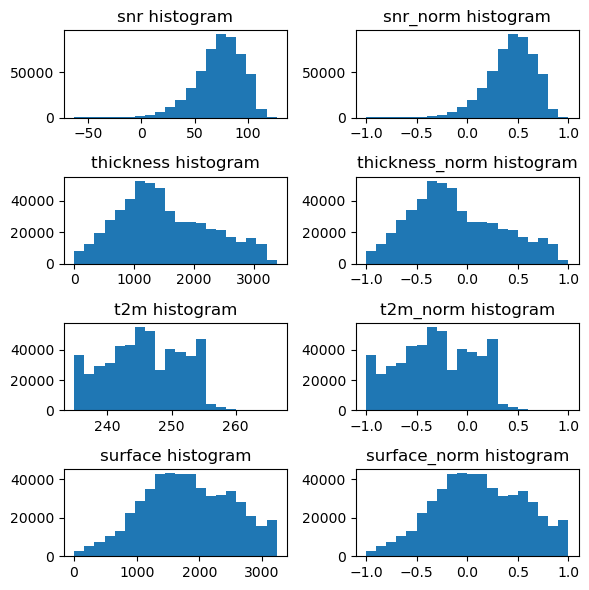

In [4]:
vars_to_norm = ['snr', 'thickness', 't2m', 'surface']

# Normalize inputs and outputs
normalization_parameters = {}
for var in vars_to_norm:
    input_df[var + "_norm"], normalization_parameters[var] = fit_combo_scaler(input_df[var])

# Plot histograms with/without normalization

fig, axs = plt.subplots(len(vars_to_norm), 2, figsize=(6, 1.5 * len(vars_to_norm)))
for i, var in enumerate(vars_to_norm):
    axs[i, 0].hist(input_df[var], bins=20)
    axs[i, 0].set_title(f"{var} histogram")
    axs[i, 1].hist(input_df[var + "_norm"], bins=20)
    axs[i, 1].set_title(f"{var}_norm histogram")

fig.tight_layout()

### Model training

In [5]:
def ln_like(theta, thickness_obs, surf_temp_obs, surf_elev_obs, snr_sim):
    beta_0, beta_thickness, beta_surf_temp, beta_surf_elev = theta
    model = beta_0 * np.exp(beta_thickness*thickness_obs +
                            beta_surf_temp*surf_temp_obs +
                            beta_surf_elev*surf_elev_obs
                           )
    
    ln_z = -0.5 * np.sum((snr_sim - model)**2 + np.log(2*np.pi))
    
    return ln_z

In [6]:
nll = lambda *args: -ln_like(*args)
initial = np.repeat(0.0,4) + 0.1 * np.random.randn(4)
likelihood = scipy.optimize.minimize(nll, initial, 
                      args=(input_df['thickness_norm'], input_df['t2m_norm'],
                            input_df['surface_norm'], input_df['snr_norm']), 
                      method='BFGS')
beta_0_ml, beta_thickness_ml, beta_surf_temp_ml, beta_surf_elev_ml = likelihood.x

In [7]:
model = pm.Model()

with model:

    # Define weakly informative Normal priors for Ridge regression
    sigma = pm.HalfNormal("sigma", 1) #recommended for StudentT
    b0 = pm.Normal("intercept", beta_0_ml, sigma=10)
    b1 = pm.Normal("beta_thickness", beta_thickness_ml, sigma=10)
    b2 = pm.Normal("beta_surface_temp", beta_surf_temp_ml, sigma=10)
    b3 = pm.Normal("beta_surface_elev", beta_surf_elev_ml, sigma=10)
    # b_EX = pm.Normal("name", 0, sigma=0.1) #heavily regularizing prior, might be useful for colinear situations ahead
    
    d1 = pm.Data("thickness_norm", input_df['thickness_norm'])
    d2 = pm.Data("t2m_norm", input_df['t2m_norm'])
    d3 = pm.Data("surface_norm", input_df['surface_norm'])

    # Define linear model
    y_est = b0 + b1*d1 + b2*d2 + b3*d3

    # Define prior for StudentT degrees of freedom
    # Inverse Gamma is recommended
    nu = pm.InverseGamma("nu", alpha=1, beta=1)

    # Define Student T likelihood, because of the presence of outliers
    likelihood = pm.StudentT(
        "likelihood", mu=y_est, sigma=sigma, nu=nu, observed=input_df['snr_norm']
    )
    
    trace = pm.sample(1000, cores=3,
                          target_accept=0.8)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, intercept, beta_thickness, beta_surface_temp, beta_surface_elev, nu]


Output()

Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 557 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


### Plot results

<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_25634/1396668332.py:9: SyntaxWarning: invalid escape sequence '\s'
  '$\sigma$'], color='#1f77b4',


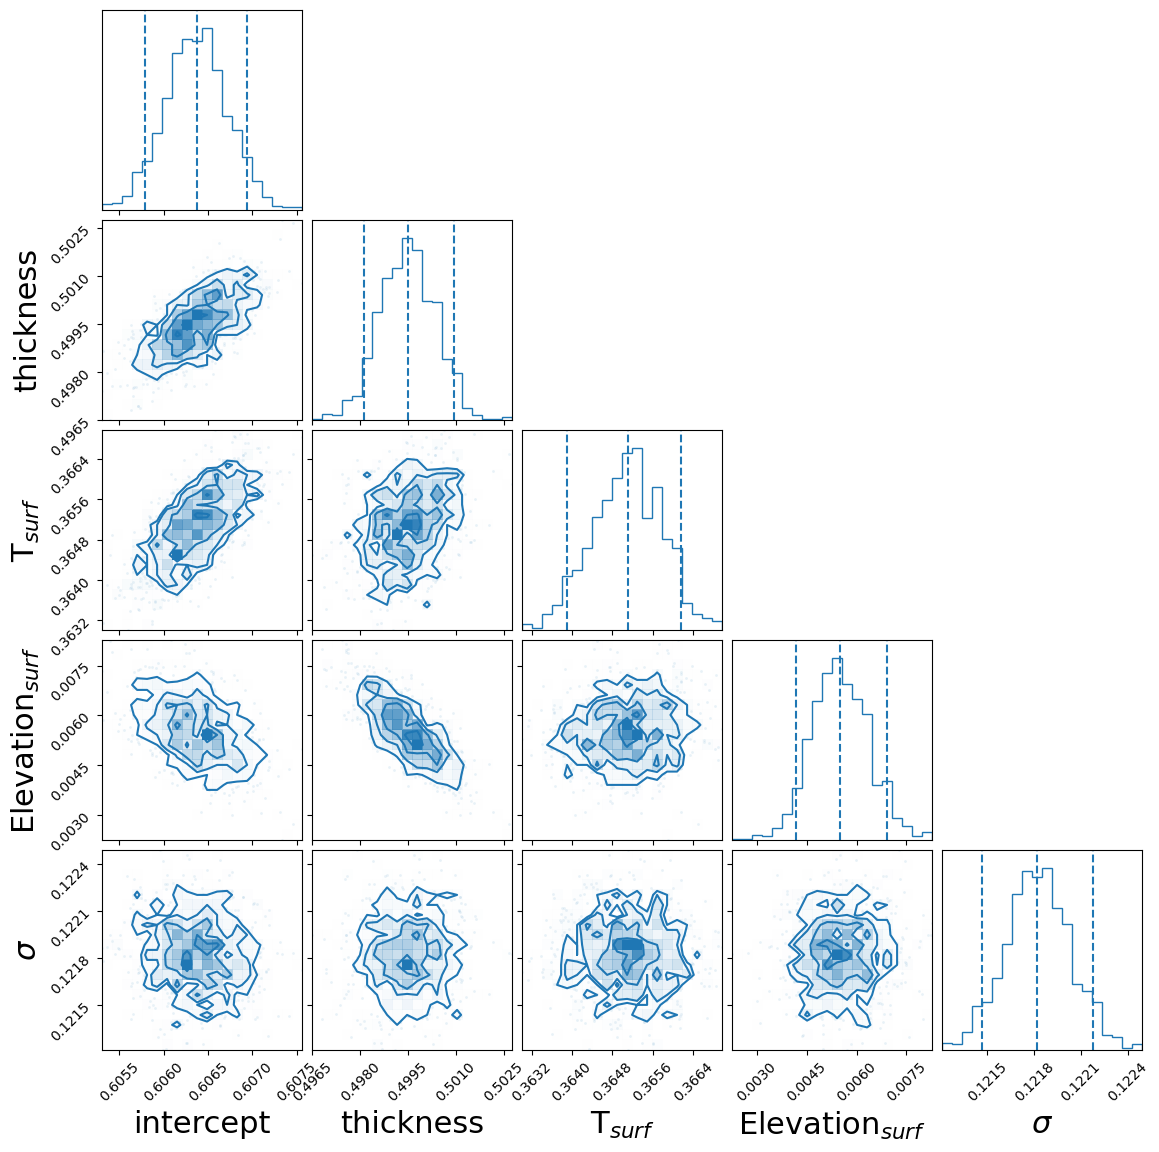

In [8]:
# Corner plot
fig = corner.corner(np.vstack((trace.posterior['intercept'][0],
                               trace.posterior['beta_thickness'][0],
                               trace.posterior['beta_surface_temp'][0],
                               trace.posterior['beta_surface_elev'][0],
                               trace.posterior['sigma'][0])).T, 
                    labels = ['intercept', 'thickness', 
                              'T$_{surf}$', 'Elevation$_{surf}$',
                              '$\sigma$'], color='#1f77b4',
                    alpha=0.25, 
                    label_kwargs={"fontsize": 22, "labelpad": 5}, 
                    quantiles=[0.05, 0.5, 0.95])

In [9]:
az.summary(trace, hdi_prob = 0.68, round_to=3).loc[['intercept', 
                                                    'beta_thickness', 
                                                    'beta_surface_temp',
                                                    'beta_surface_elev', 
                                                    'sigma'], :]

,mean,sd,hdi_16%,hdi_84%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.606,0.000,0.606,0.607,0.0,0.0,1190.488,1229.452,1.000
beta_thickness,0.499,0.001,0.499,0.500,0.0,0.0,1171.306,1166.297,1.001
beta_surface_temp,0.365,0.001,0.364,0.366,0.0,0.0,1707.097,1660.548,1.001
beta_surface_elev,0.006,0.001,0.005,0.006,0.0,0.0,1546.442,1750.109,1.000
sigma,0.122,0.000,0.122,0.122,0.0,0.0,2077.791,1556.567,1.003


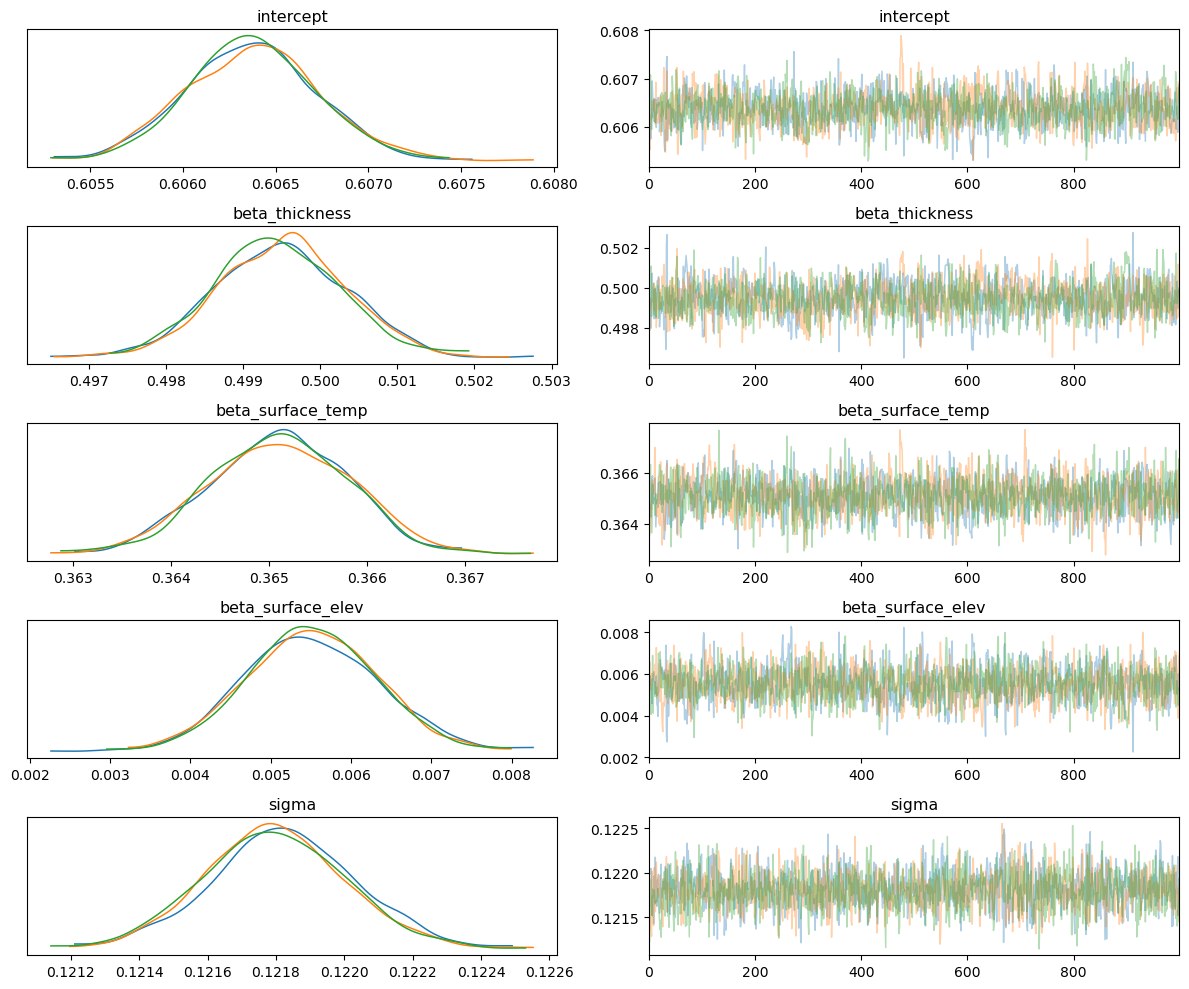

In [10]:
az.plot_trace(trace, 
              var_names=['intercept', 'beta_thickness', 
                         'beta_surface_temp', 'beta_surface_elev', 
                         'sigma'], 
              combined=False, compact=False)
plt.tight_layout()

In [11]:
results = {
    'dataset_name': dataset_name,
    'ice_sheet': ice_sheet,
    'bm_mask_whitelist': bm_mask_whitelist,
    'input_data_path': input_data_path,
    'trace': trace,
    'model': model,
    'normalization_parameters': normalization_parameters
}

# Save the model
with open(f"outputs/{dataset_name}_model.pickle", "wb") as f:
    cloudpickle.dump(results, f)